<a href="https://colab.research.google.com/github/phmouras/Python_Projects/blob/main/AnomalyDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Iniciando Análise de Anomalias - PaySmart Solutions

📥 Carregando dados...
📋 Definindo regras de negócio...
🔧 Aplicando feature engineering...
✅ Validando regras de negócio...
🤖 Preparando dados para Machine Learning...
🌲 Treinando Isolation Forest...
🔍 Aplicando análise de clustering...
📊 Gerando relatório...
RELATÓRIO DE ANOMALIAS - PAYSMART SOLUTIONS

📊 ESTATÍSTICAS GERAIS:
   • Total de transações analisadas: 10000
   • Anomalias por regras de negócio: 12292
   • Anomalias por ML (Isolation Forest): 1000
   • Anomalias por Clustering: 10000

🚨 ANOMALIAS POR TIPO (Regras de Negócio):
   • VARIACAO_EXCESSIVA: 8497 casos
   • TAXA_ACIMA_MAXIMO: 2270 casos
   • COBRANCA_INDEVIDA_ISENTO: 1495 casos
   • TAXA_ZERO_NAO_ISENTO: 30 casos

⚠️  SEVERIDADE DAS ANOMALIAS:
   • ALTA: 9075 casos
   • MEDIA: 3217 casos

🏪 TOP 10 ESTABELECIMENTOS COM MAIS ANOMALIAS:
   • Estabelecimento 685: 27 anomalias (R$ 3549.08)
   • Estabelecimento 725: 27 anomalias (R$ 2915.73)
   • Estabelecimento 984: 26

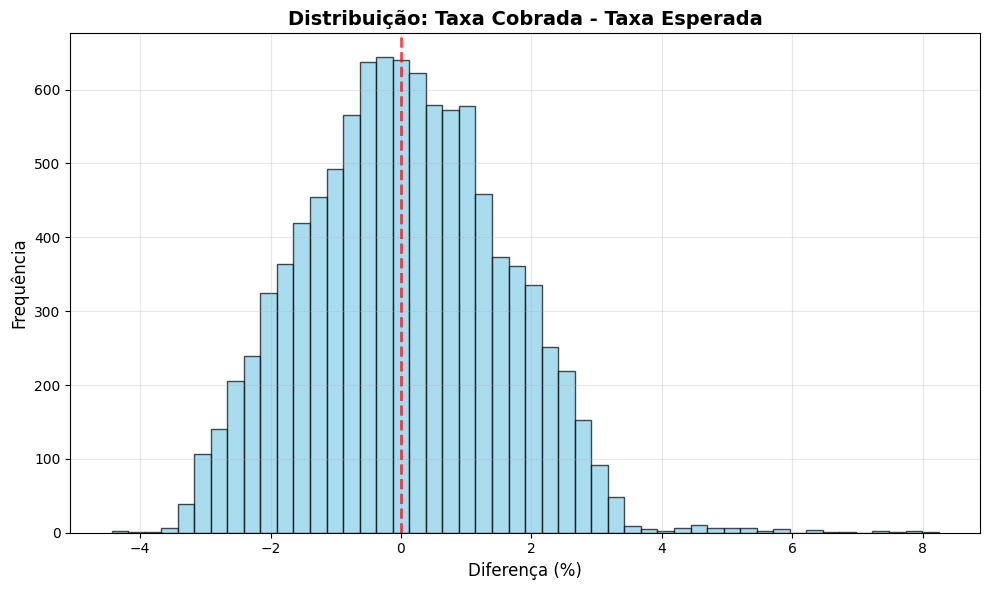

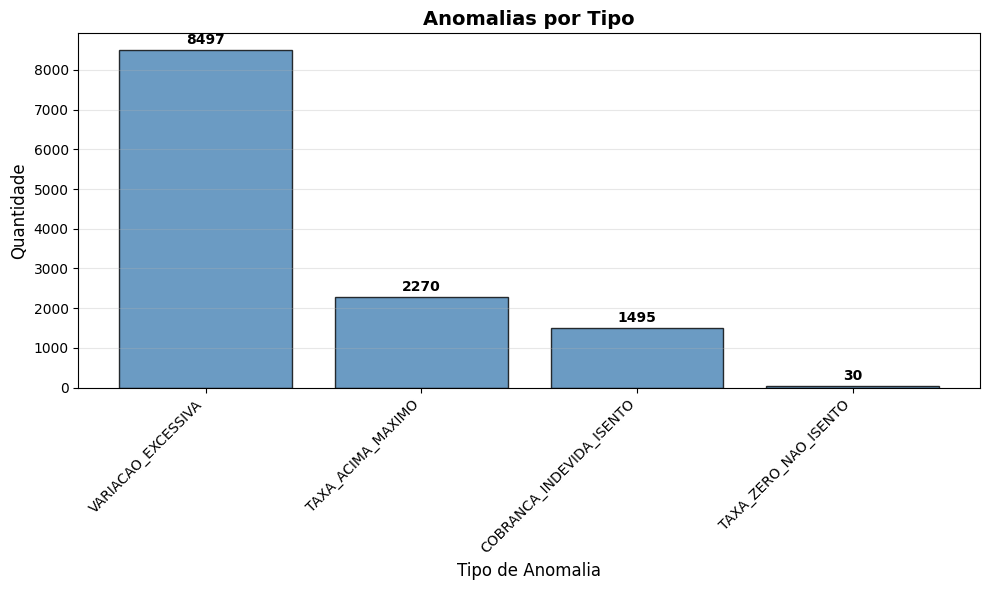

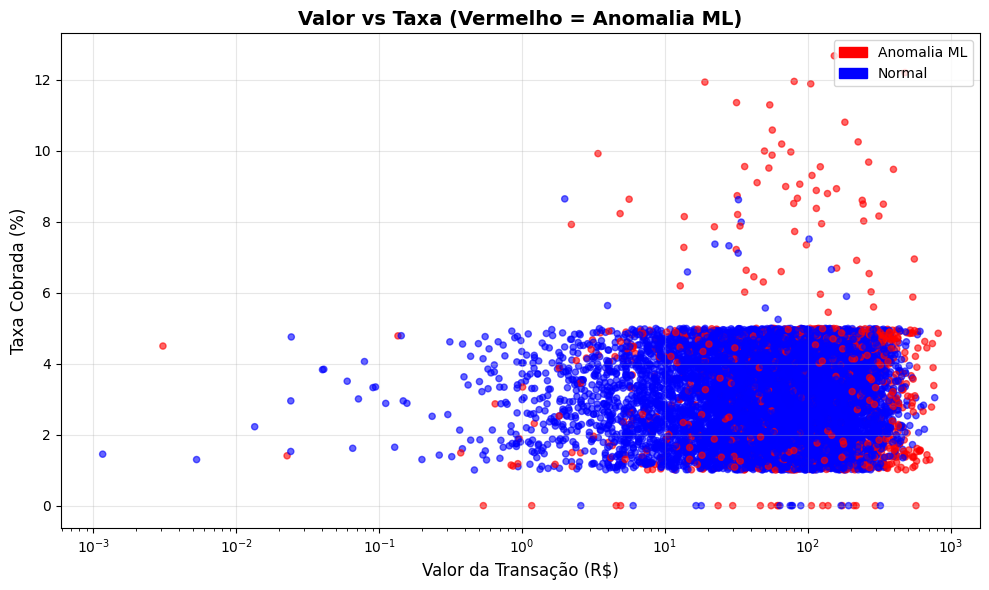

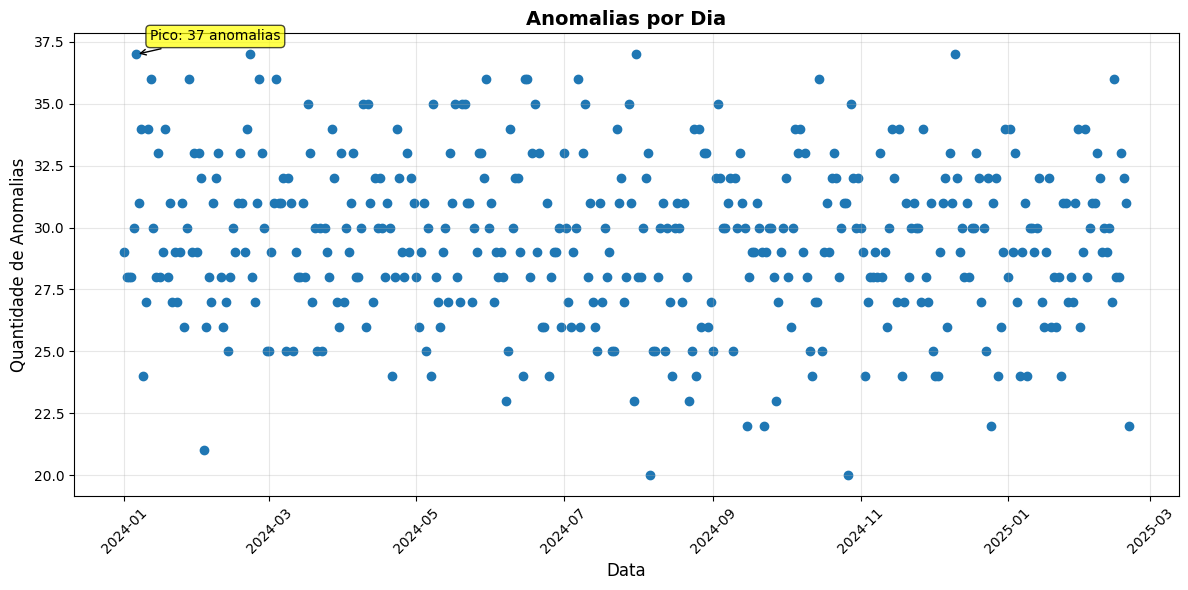


✅ ANÁLISE CONCLUÍDA COM SUCESSO!


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import logging


from sklearn.ensemble import IsolationForest        # Identifica padrões anômalos em múltiplas dimensões
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN                  #  Detecta outliers através de análise de densidade
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

class PaySmartAnomalyDetector:    #Sistema de Detecção de Anomalias para Cobrança de Taxas

    def __init__(self):
        self.isolation_forest = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.regras_negocio = {}

    def carregar_dados_simulados(self):

        #Simula dados de transações para demonstração
        np.random.seed(42)
        n_transacoes = 10000

        # Dados base das transações
        dados = {
            'id_transacao': range(1, n_transacoes + 1),
            'valor_transacao': np.random.exponential(100, n_transacoes),
            'tipo_estabelecimento': np.random.choice(['RETAIL', 'ECOMMERCE', 'RESTAURANTE', 'POSTO', 'FARMACIA'], n_transacoes), # uniform random sample from [] of size n_transacoes:
            'categoria_mcc': np.random.choice(['5411', '5812', '5541', '5912', '4111'], n_transacoes),
            'bandeira': np.random.choice(['VISA', 'MASTERCARD', 'ELO', 'AMEX'], n_transacoes),
            'tipo_transacao': np.random.choice(['CREDITO', 'DEBITO', 'PIX'], n_transacoes),
            'data_transacao': pd.date_range('2024-01-01', periods=n_transacoes, freq='H'),
            'id_estabelecimento': np.random.randint(1, 1000, n_transacoes),
            'taxa_esperada': np.random.uniform(1.5, 4.5, n_transacoes),  # % esperado
            'taxa_cobrada': np.random.uniform(1.0, 5.0, n_transacoes),   # % cobrado
            'isento': np.random.choice([True, False], n_transacoes, p=[0.15, 0.85]),  # p = probabilidade associada a [True, False].
            'volume_mensal_estabelecimento': np.random.exponential(50000, n_transacoes)
        }

        df = pd.DataFrame(dados)

        # Simular algumas anomalias intencionais
        # 1. Cobrança quando deveria ser isento
        indices_erro_isencao = np.random.choice(df[df['isento'] == True].index, 50, replace=False)
        df.loc[indices_erro_isencao, 'taxa_cobrada'] = np.random.uniform(2.0, 4.0, 50)

        # 2. Taxa muito acima do esperado
        indices_taxa_alta = np.random.choice(df.index, 100, replace=False)
        df.loc[indices_taxa_alta, 'taxa_cobrada'] = df.loc[indices_taxa_alta, 'taxa_esperada'] * np.random.uniform(2.0, 3.0, 100)

        # 3. Taxa zero quando não deveria ser isento
        indices_taxa_zero = np.random.choice(df[df['isento'] == False].index, 30, replace=False)
        df.loc[indices_taxa_zero, 'taxa_cobrada'] = 0

        return df

     #def carregar_dados_reais(self):
        # Conectar ao banco de dados da PaySmart

          #VALIDAÇÃO DE DADOS
    def validar_integridade_dados(self, df):
          """Valida a integridade e qualidade dos dados"""
          problemas = []

          # Verificar valores nulos
          nulos = df.isnull().sum()
          if nulos.any():
              problemas.append(f"Valores nulos encontrados: {nulos[nulos > 0].to_dict()}")

          # Verificar valores negativos onde não deveria haver
          if (df['valor_transacao'] < 0).any():
              problemas.append("Valores de transação negativos detectados")

          if (df['taxa_cobrada'] < 0).any():
              problemas.append("Taxas cobradas negativas detectadas")

          # Verificar datas futuras
          data_futura = df['data_transacao'] > pd.Timestamp.now()
          if data_futura.any():
              problemas.append(f"Transações com data futura: {data_futura.sum()}")

          return problemas

    # SISTEMA DE ALERTAS AUTOMATIZADOS
    def configurar_alertas(self):
          """Configura sistema de alertas"""
          self.config_alertas = {
              'email_compliance': 'compliance@paysmart.com',
              'email_ti': 'ti@paysmart.com',
              'threshold_critico': 80,
              'threshold_alto': 60
          }

    def enviar_alerta(self, nivel, detalhes):   # Envia alertas baseados no nível de severidade

          if nivel == 'CRITICO':
              # Enviar email imediato + SMS (exemplo)
              self.enviar_email_urgente(detalhes)
              self.enviar_sms_alerta(detalhes)
          elif nivel == 'ALTO':
              # Enviar email
              self.enviar_email_alerta(detalhes)


    def definir_regras_negocio(self):

     self.regras_negocio = {
            'taxa_maxima_por_bandeira': {
                'VISA': 4.0,
                'MASTERCARD': 4.0,
                'ELO': 3.5,
                'AMEX': 5.0
            },
            'taxa_minima_geral': 0.5,
            'tolerancia_variacao': 0.3,  # 30 pontos base de tolerância
            'volume_isencao_minimo': 100000,  # Volume mínimo para isenção automática
            'categorias_isencao_especial': ['5411', '5912'],  # MCCs com regras especiais
        }

    def aplicar_feature_engineering(self, df):      #  Cria variáveis(features) derivadas relevantes para a análise

        df_features = df.copy()

        # Features de diferença e proporção:
        df_features['diferenca_taxa'] = df_features['taxa_cobrada'] - df_features['taxa_esperada']
        df_features['proporcao_taxa'] = df_features['taxa_cobrada'] / (df_features['taxa_esperada'] + 0.001)
        df_features['valor_taxa_absoluto'] = df_features['valor_transacao'] * df_features['taxa_cobrada'] / 100

        # Features temporais
        df_features['hora'] = df_features['data_transacao'].dt.hour
        df_features['dia_semana'] = df_features['data_transacao'].dt.dayofweek
        df_features['mes'] = df_features['data_transacao'].dt.month

        # Features de volume
        df_features['ticket_medio_estabelecimento'] = df_features.groupby('id_estabelecimento')['valor_transacao'].transform('mean')
        df_features['volume_diario_estabelecimento'] = df_features.groupby(['id_estabelecimento', df_features['data_transacao'].dt.date])['valor_transacao'].transform('sum')

        # Flags de anomalia potencial
        df_features['flag_isento_cobrado'] = (df_features['isento'] == True) & (df_features['taxa_cobrada'] > 0)
        df_features['flag_taxa_zero_nao_isento'] = (df_features['isento'] == False) & (df_features['taxa_cobrada'] == 0)
        df_features['flag_taxa_muito_alta'] = df_features['proporcao_taxa'] > 1.5
        df_features['flag_taxa_muito_baixa'] = (df_features['proporcao_taxa'] < 0.5) & (df_features['isento'] == False)

        return df_features

    def validar_regras_negocio(self, df):   # Validações baseadas em regras de negócio

        anomalias_regras = []

        for idx, row in df.iterrows():
            anomalias_transacao = []

            # Regra 1: Cobrança em transação isenta
            if row['isento'] and row['taxa_cobrada'] > 0:
                anomalias_transacao.append({
                    'tipo': 'COBRANCA_INDEVIDA_ISENTO',
                    'severidade': 'ALTA',
                    'descricao': f'Taxa cobrada ({row["taxa_cobrada"]:.2f}%) em transação isenta'
                })

            # Regra 2: Taxa acima do máximo por bandeira
            taxa_max = self.regras_negocio['taxa_maxima_por_bandeira'].get(row['bandeira'], 5.0)
            if row['taxa_cobrada'] > taxa_max:
                anomalias_transacao.append({
                    'tipo': 'TAXA_ACIMA_MAXIMO',
                    'severidade': 'ALTA',
                    'descricao': f'Taxa ({row["taxa_cobrada"]:.2f}%) acima do máximo para {row["bandeira"]} ({taxa_max}%)'
                })

            # Regra 3: Variação excessiva da taxa esperada
            if abs(row['diferenca_taxa']) > self.regras_negocio['tolerancia_variacao']:
                severidade = 'ALTA' if abs(row['diferenca_taxa']) > 1.0 else 'MEDIA'
                anomalias_transacao.append({
                    'tipo': 'VARIACAO_EXCESSIVA',
                    'severidade': severidade,
                    'descricao': f'Diferença de {row["diferenca_taxa"]:.2f}% entre taxa cobrada e esperada'
                })

            # Regra 4: Taxa zero em não isentos
            if not row['isento'] and row['taxa_cobrada'] == 0:
                anomalias_transacao.append({
                    'tipo': 'TAXA_ZERO_NAO_ISENTO',
                    'severidade': 'ALTA',
                    'descricao': 'Taxa zero em transação não isenta'
                })

            if anomalias_transacao:
                for anomalia in anomalias_transacao:
                    anomalias_regras.append({
                        'id_transacao': row['id_transacao'],
                        'data_transacao': row['data_transacao'],
                        'valor_transacao': row['valor_transacao'],
                        'estabelecimento': row['id_estabelecimento'],
                        **anomalia
                    })

        return pd.DataFrame(anomalias_regras)

    def preparar_dados_ml(self, df):        # Prepara dados para algoritmos de Machine Learning


        features_numericas = [
            'valor_transacao', 'taxa_esperada', 'taxa_cobrada', 'diferenca_taxa',
            'proporcao_taxa', 'volume_mensal_estabelecimento', 'hora', 'dia_semana'
        ]

        features_categoricas = ['tipo_estabelecimento', 'bandeira', 'tipo_transacao', 'categoria_mcc']

        df_ml = df[features_numericas + features_categoricas + ['isento']].copy()

        # Encoding de variáveis categóricas
        for col in features_categoricas:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                df_ml[col] = self.label_encoders[col].fit_transform(df_ml[col].astype(str))  # converte dados categoricos em números
            else:
                df_ml[col] = self.label_encoders[col].transform(df_ml[col].astype(str))

        # Converter bool para int
        df_ml['isento'] = df_ml['isento'].astype(int)

        return df_ml[features_numericas + features_categoricas + ['isento']]

    def treinar_isolation_forest(self, df_ml):    # Separa dados a partir de árvores binárias aleatórias (GLOBAL)

        # Normalização
        X_scaled = self.scaler.fit_transform(df_ml)         # mean=0 std=1

        # Treinar Isolation Forest
        self.isolation_forest = IsolationForest(
            contamination=0.1,  # Esperamos ~10% de anomalias
            random_state=42,
            n_estimators=100
        )

        anomalia_scores = self.isolation_forest.fit_predict(X_scaled)              # Treina e classifica: 1 = normal, -1 = anomalia
        anomalia_scores_prob = self.isolation_forest.decision_function(X_scaled)

        # Análise de performance(Previsto x Real)
        if 'anomalia_real' in df_ml.columns:
            from sklearn.metrics import classification_report
            y_pred = (anomalia_scores == -1).astype(int)
            y_true = df['anomalia_real'].values

            print(f"\n🎯 AVALIAÇÃO DE PERFORMANCE:")
            print("   Comparando com anomalias conhecidas:")
            print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalia']))

        return anomalia_scores, anomalia_scores_prob

    def detectar_anomalias_clustering(self, df_ml):     # Clustering para densidade LOCAL

        X_scaled = self.scaler.transform(df_ml)     # = normalização

        # DBSCAN para clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)    # eps = raio de busca
        clusters = dbscan.fit_predict(X_scaled)

        # -1 = outliers
        outliers = (clusters == -1)

        return outliers

    def gerar_relatorio_anomalias(self, df, anomalias_regras, anomalias_ml, anomalias_clustering):

        print("="*80)
        print("RELATÓRIO DE ANOMALIAS - PAYSMART SOLUTIONS")
        print("="*80)

        # Estatísticas gerais
        total_transacoes = len(df)
        anomalias_regras_count = len(anomalias_regras)
        anomalias_ml_count = sum(anomalias_ml == -1)
        anomalias_clustering_count = sum(anomalias_clustering)

        print(f"\n📊 ESTATÍSTICAS GERAIS:")
        print(f"   • Total de transações analisadas: {total_transacoes:}")
        print(f"   • Anomalias por regras de negócio: {anomalias_regras_count:}")
        print(f"   • Anomalias por ML (Isolation Forest): {anomalias_ml_count:}")
        print(f"   • Anomalias por Clustering: {anomalias_clustering_count:}")

        # Análise por tipo de anomalia
        if len(anomalias_regras) > 0:
            print(f"\n🚨 ANOMALIAS POR TIPO (Regras de Negócio):")
            tipo_count = anomalias_regras['tipo'].value_counts()
            for tipo, count in tipo_count.items():
                print(f"   • {tipo}: {count:} casos")

            print(f"\n⚠️  SEVERIDADE DAS ANOMALIAS:")
            sev_count = anomalias_regras['severidade'].value_counts()
            for sev, count in sev_count.items():
                print(f"   • {sev}: {count:} casos")

        # Top estabelecimentos com anomalias
        if len(anomalias_regras) > 0:
            print(f"\n🏪 TOP 10 ESTABELECIMENTOS COM MAIS ANOMALIAS:")
            top_estabelecimentos = anomalias_regras['estabelecimento'].value_counts().head(10)
            for estab, count in top_estabelecimentos.items():
                valor_total_anomalo = anomalias_regras[anomalias_regras['estabelecimento'] == estab]['valor_transacao'].sum()
                print(f"   • Estabelecimento {estab}: {count} anomalias (R$ {valor_total_anomalo:.2f})")

        # Impacto financeiro
        if len(anomalias_regras) > 0:
            impacto_financeiro = anomalias_regras['valor_transacao'].sum()
            print(f"\n💰 IMPACTO FINANCEIRO ESTIMADO:")
            print(f"   • Volume total das transações com anomalias: R$ {impacto_financeiro:.2f}")

            # Análise temporal
            anomalias_regras['data'] = pd.to_datetime(anomalias_regras['data_transacao']).dt.date
            anomalias_por_dia = anomalias_regras.groupby('data').size()
            print(f"   • Média de anomalias por dia: {anomalias_por_dia.mean():.1f}")
            print(f"   • Dia com mais anomalias: {anomalias_por_dia.idxmax()} ({anomalias_por_dia.max()} casos)")

    def plotar_analises(self, df, anomalias_regras, anomalias_ml):

        # 1. Distribuição de diferenças de taxa
        plt.figure(figsize=(10, 6))
        plt.hist(df['diferenca_taxa'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.title('Distribuição: Taxa Cobrada - Taxa Esperada', fontsize=14, fontweight='bold')
        plt.xlabel('Diferença (%)', fontsize=12)
        plt.ylabel('Frequência', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('distribuicao_diferenca_taxa.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. Anomalias por tipo (regras)
        if len(anomalias_regras) > 0:
            plt.figure(figsize=(10, 6))
            tipo_count = anomalias_regras['tipo'].value_counts()
            bars = plt.bar(range(len(tipo_count)), tipo_count.values,
                          color='steelblue', alpha=0.8, edgecolor='black')
            plt.xticks(range(len(tipo_count)), tipo_count.index, rotation=45, ha='right')
            plt.title('Anomalias por Tipo', fontsize=14, fontweight='bold')
            plt.ylabel('Quantidade', fontsize=12)
            plt.xlabel('Tipo de Anomalia', fontsize=12)

            # Adicionar valores nas barras
            for bar, value in zip(bars, tipo_count.values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(tipo_count.values),
                        str(value), ha='center', va='bottom', fontweight='bold')

            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.savefig('anomalias_por_tipo.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("Nenhuma anomalia por regras encontrada para plotar.")

        # 3. Scatter: Valor vs Taxa Cobrada (colorido por anomalias ML)
        plt.figure(figsize=(10, 6))
        cores = ['red' if x == -1 else 'blue' for x in anomalias_ml]
        scatter = plt.scatter(df['valor_transacao'], df['taxa_cobrada'],
                            c=cores, alpha=0.6, s=20)
        plt.title('Valor vs Taxa (Vermelho = Anomalia ML)', fontsize=14, fontweight='bold')
        plt.xlabel('Valor da Transação (R$)', fontsize=12)
        plt.ylabel('Taxa Cobrada (%)', fontsize=12)
        plt.xscale('log')

        # Adicionar legenda
        import matplotlib.patches as mpatches
        red_patch = mpatches.Patch(color='red', label='Anomalia ML')
        blue_patch = mpatches.Patch(color='blue', label='Normal')
        plt.legend(handles=[red_patch, blue_patch], loc='upper right')

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('valor_vs_taxa_ml.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 4. Série temporal de anomalias
        if len(anomalias_regras) > 0:
            plt.figure(figsize=(12, 6))
            # Criar cópia para não modificar o DataFrame original
            anomalias_temp = anomalias_regras.copy()
            anomalias_temp['data'] = pd.to_datetime(anomalias_temp['data_transacao']).dt.date
            anomalias_diarias = anomalias_temp.groupby('data').size()

            plt.scatter(anomalias_diarias.index, anomalias_diarias.values,
                    colorizer='steelblue')
            plt.title('Anomalias por Dia', fontsize=14, fontweight='bold')
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Quantidade de Anomalias', fontsize=12)
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)

            # Destacar picos
            max_anomalias = anomalias_diarias.max()
            max_data = anomalias_diarias.idxmax()
            plt.annotate(f'Pico: {max_anomalias} anomalias',
                        xy=(max_data, max_anomalias),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

            plt.tight_layout()
            plt.savefig('anomalias_por_dia.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("Nenhuma anomalia por regras encontrada para plotar série temporal.")


    def executar_analise_completa(self):

        print("🚀 Iniciando Análise de Anomalias - PaySmart Solutions\n")

        # 1. Carregar dados
        print("📥 Carregando dados...")
        df = self.carregar_dados_simulados()

        # 2. Definir regras de negócio
        print("📋 Definindo regras de negócio...")
        self.definir_regras_negocio()

        # 3. Feature Engineering
        print("🔧 Aplicando feature engineering...")
        df = self.aplicar_feature_engineering(df)

        # 4. Validação por regras de negócio
        print("✅ Validando regras de negócio...")
        anomalias_regras = self.validar_regras_negocio(df)

        # 5. Preparar dados para ML
        print("🤖 Preparando dados para Machine Learning...")
        df_ml = self.preparar_dados_ml(df)

        # 6. Detecção com Isolation Forest
        print("🌲 Treinando Isolation Forest...")
        anomalias_ml, scores_ml = self.treinar_isolation_forest(df_ml)

        # 7. Detecção com Clustering
        print("🔍 Aplicando análise de clustering...")
        anomalias_clustering = self.detectar_anomalias_clustering(df_ml)

        # 8. Gerar relatório
        print("📊 Gerando relatório...")
        self.gerar_relatorio_anomalias(df, anomalias_regras, anomalias_ml, anomalias_clustering)

        # 9. Visualizações
        print("\n📈 Gerando visualizações...")
        self.plotar_analises(df, anomalias_regras, anomalias_ml)

        # Retornar dados para análise posterior
        return {
            'dados': df,
            'anomalias_regras': anomalias_regras,
            'anomalias_ml': anomalias_ml,
            'scores_ml': scores_ml,
            'anomalias_clustering': anomalias_clustering
        }

    def monitoramento_tempo_real(self, nova_transacao):
        """
        Função para monitoramento em tempo real de novas transações
        Aplica feature engineering, verifica regras de negócio e usa modelos ML

        Args:
            nova_transacao (dict): Dicionário com dados da nova transação

        Returns:
            dict: Resultado da análise com alertas e scores
        """

        # Verificar se os modelos foram treinados
        if not self.modelo_treinado or self.isolation_forest is None:
            return {
                'erro': 'Modelos não treinados. Execute executar_analise_completa() primeiro.',
                'status': 'ERRO'
            }

        try:
            # 1. Converter para DataFrame
            df_nova = pd.DataFrame([nova_transacao])

            # Validar campos obrigatórios
            campos_obrigatorios = [
                'id_transacao', 'valor_transacao', 'tipo_estabelecimento', 'categoria_mcc',
                'bandeira', 'tipo_transacao', 'data_transacao', 'id_estabelecimento',
                'taxa_esperada', 'taxa_cobrada', 'isento', 'volume_mensal_estabelecimento'
            ]

            campos_faltantes = [campo for campo in campos_obrigatorios if campo not in df_nova.columns]
            if campos_faltantes:
                return {
                    'erro': f'Campos obrigatórios faltantes: {campos_faltantes}',
                    'status': 'ERRO'
                }

            # 2. Converter data_transacao se necessário
            if not pd.api.types.is_datetime64_any_dtype(df_nova['data_transacao']):
                df_nova['data_transacao'] = pd.to_datetime(df_nova['data_transacao'])

            # 3. Aplicar feature engineering
            df_features = self.aplicar_feature_engineering_single(df_nova)

            # 4. Verificar regras de negócio
            anomalias_regras = self.validar_regras_negocio_single(df_features.iloc[0])

            # 5. Preparar dados para ML
            df_ml = self.preparar_dados_ml_single(df_features)

            # 6. Aplicar modelos ML treinados
            score_ml = self.detectar_anomalia_ml_single(df_ml)

            # 7. Calcular score de risco geral
            score_risco = self.calcular_score_risco(anomalias_regras, score_ml)

            # 8. Determinar ação recomendada
            acao_recomendada = self.determinar_acao(score_risco, anomalias_regras)

            # 9. Montar resultado
            resultado = {
                'id_transacao': nova_transacao['id_transacao'],
                'timestamp_analise': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'status': 'SUCESSO',
                'score_risco': score_risco,
                'score_ml': float(score_ml),
                'anomalias_regras': anomalias_regras,
                'acao_recomendada': acao_recomendada,
                'detalhes': {
                    'valor_transacao': nova_transacao['valor_transacao'],
                    'taxa_cobrada': nova_transacao['taxa_cobrada'],
                    'taxa_esperada': nova_transacao['taxa_esperada'],
                    'diferenca_taxa': nova_transacao['taxa_cobrada'] - nova_transacao['taxa_esperada'],
                    'estabelecimento': nova_transacao['id_estabelecimento'],
                    'bandeira': nova_transacao['bandeira']
                }
            }

            return resultado

        except Exception as e:
            return {
                'erro': f'Erro durante análise: {str(e)}',
                'status': 'ERRO',
                'id_transacao': nova_transacao.get('id_transacao', 'N/A')
            }

    def aplicar_feature_engineering_single(self, df):   # Aplica feature engineering para uma única transação

        df_features = df.copy()

        # Features básicas
        df_features['diferenca_taxa'] = df_features['taxa_cobrada'] - df_features['taxa_esperada']
        df_features['proporcao_taxa'] = df_features['taxa_cobrada'] / (df_features['taxa_esperada'] + 0.001)
        df_features['valor_taxa_absoluto'] = df_features['valor_transacao'] * df_features['taxa_cobrada'] / 100

        # Features temporais
        df_features['hora'] = df_features['data_transacao'].dt.hour
        df_features['dia_semana'] = df_features['data_transacao'].dt.dayofweek
        df_features['mes'] = df_features['data_transacao'].dt.month

        # Para uma única transação, usar valores médios dos dados históricos se disponível
        if self.dados_historicos is not None:
            # Calcular ticket médio do estabelecimento usando dados históricos
            estab_id = df_features['id_estabelecimento'].iloc[0]
            dados_estab = self.dados_historicos[self.dados_historicos['id_estabelecimento'] == estab_id]

            if len(dados_estab) > 0:
                df_features['ticket_medio_estabelecimento'] = dados_estab['valor_transacao'].mean()
                df_features['volume_diario_estabelecimento'] = dados_estab['valor_transacao'].sum()
            else:
                df_features['ticket_medio_estabelecimento'] = df_features['valor_transacao']
                df_features['volume_diario_estabelecimento'] = df_features['valor_transacao']
        else:
            df_features['ticket_medio_estabelecimento'] = df_features['valor_transacao']
            df_features['volume_diario_estabelecimento'] = df_features['valor_transacao']

        # Flags de anomalia
        df_features['flag_isento_cobrado'] = (df_features['isento'] == True) & (df_features['taxa_cobrada'] > 0)
        df_features['flag_taxa_zero_nao_isento'] = (df_features['isento'] == False) & (df_features['taxa_cobrada'] == 0)
        df_features['flag_taxa_muito_alta'] = df_features['proporcao_taxa'] > 1.5
        df_features['flag_taxa_muito_baixa'] = (df_features['proporcao_taxa'] < 0.5) & (df_features['isento'] == False)

        return df_features

    def validar_regras_negocio_single(self, row):
        """Valida regras de negócio para uma única transação"""
        anomalias = []

        # Regra 1: Cobrança em transação isenta
        if row['isento'] and row['taxa_cobrada'] > 0:
            anomalias.append({
                'tipo': 'COBRANCA_INDEVIDA_ISENTO',
                'severidade': 'ALTA',
                'descricao': f'Taxa cobrada ({row["taxa_cobrada"]:.2f}%) em transação isenta'
            })

        # Regra 2: Taxa acima do máximo por bandeira
        taxa_max = self.regras_negocio['taxa_maxima_por_bandeira'].get(row['bandeira'], 5.0)
        if row['taxa_cobrada'] > taxa_max:
            anomalias.append({
                'tipo': 'TAXA_ACIMA_MAXIMO',
                'severidade': 'ALTA',
                'descricao': f'Taxa ({row["taxa_cobrada"]:.2f}%) acima do máximo para {row["bandeira"]} ({taxa_max}%)'
            })

        # Regra 3: Variação excessiva da taxa esperada
        diferenca = abs(row['diferenca_taxa'])
        if diferenca > self.regras_negocio['tolerancia_variacao']:
            severidade = 'ALTA' if diferenca > 1.0 else 'MEDIA'
            anomalias.append({
                'tipo': 'VARIACAO_EXCESSIVA',
                'severidade': severidade,
                'descricao': f'Diferença de {row["diferenca_taxa"]:.2f}% entre taxa cobrada e esperada'
            })

        # Regra 4: Taxa zero em não isentos
        if not row['isento'] and row['taxa_cobrada'] == 0:
            anomalias.append({
                'tipo': 'TAXA_ZERO_NAO_ISENTO',
                'severidade': 'ALTA',
                'descricao': 'Taxa zero em transação não isenta'
            })

        return anomalias

    def preparar_dados_ml_single(self, df):
        """Prepara dados ML para uma única transação"""
        features_numericas = [
            'valor_transacao', 'taxa_esperada', 'taxa_cobrada', 'diferenca_taxa',
            'proporcao_taxa', 'volume_mensal_estabelecimento', 'hora', 'dia_semana'
        ]

        features_categoricas = ['tipo_estabelecimento', 'bandeira', 'tipo_transacao', 'categoria_mcc']

        df_ml = df[features_numericas + features_categoricas + ['isento']].copy()

        # Aplicar encoding usando encoders já treinados
        for col in features_categoricas:
            if col in self.label_encoders:
                try:
                    df_ml[col] = self.label_encoders[col].transform(df_ml[col].astype(str))
                except ValueError:
                    # Valor não visto durante treinamento - usar valor padrão
                    df_ml[col] = 0
            else:
                df_ml[col] = 0

        df_ml['isento'] = df_ml['isento'].astype(int)

        return df_ml[features_numericas + features_categoricas + ['isento']]

    def detectar_anomalia_ml_single(self, df_ml):
        """Detecta anomalia usando modelo ML treinado"""
        X_scaled = self.scaler.transform(df_ml)
        score = self.isolation_forest.decision_function(X_scaled)[0]
        return score

    def calcular_score_risco(self, anomalias_regras, score_ml):
        """Calcula score de risco geral (0-100)"""
        score_base = 0

        # Score baseado em regras de negócio
        for anomalia in anomalias_regras:
            if anomalia['severidade'] == 'ALTA':
                score_base += 40
            elif anomalia['severidade'] == 'MEDIA':
                score_base += 20
            else:
                score_base += 10

        # Score baseado em ML (normalizar de -1,1 para 0,50)
        score_ml_norm = max(0, (1 + score_ml) * 25)  # Converte para 0-50
        score_ml_norm = 50 - score_ml_norm  # Inverter (score baixo = risco alto)

        score_total = min(100, score_base + score_ml_norm)
        return round(score_total, 2)

    def determinar_acao(self, score_risco, anomalias_regras):
        #Determina ação recomendada baseada no score de risco"""
        if score_risco >= 80:
            return {
                'nivel': 'CRITICO',
                'acao': 'BLOQUEAR_TRANSACAO',
                'descricao': 'Transação deve ser bloqueada imediatamente para análise manual'
            }
        elif score_risco >= 60:
            return {
                'nivel': 'ALTO',
                'acao': 'REVISAR_URGENTE',
                'descricao': 'Requer revisão urgente pela equipe de compliance'
            }
        elif score_risco >= 40:
            return {
                'nivel': 'MEDIO',
                'acao': 'MONITORAR',
                'descricao': 'Adicionar à lista de monitoramento próximo'
            }
        elif score_risco >= 20:
            return {
                'nivel': 'BAIXO',
                'acao': 'LOG',
                'descricao': 'Registrar para análise posterior'
            }
        else:
            return {
                'nivel': 'NORMAL',
                'acao': 'APROVAR',
                'descricao': 'Transação dentro dos parâmetros normais'
            }


# Execução
def main():

    detector = PaySmartAnomalyDetector()
    resultados = detector.executar_analise_completa()

    return detector, resultados


# Execução do sistema
if __name__ == "__main__":
    detector, resultados = main()

    print("\n" + "="*80)
    print("✅ ANÁLISE CONCLUÍDA COM SUCESSO!")


